In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

In [3]:
# Retrieve records from 2019 only
df = pd.read_csv('/content/drive/My Drive/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df['month']=pd.to_datetime(df['month'])
df['Year'] = df['month'].apply(lambda x: x.year)
df['Month'] = df['month'].apply(lambda y: y.month)
df = df[df['Year'] == 2019]
df = df.drop(columns = ['month','Year'])
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Month
0,ANG MO KIO,3 ROOM,330,ANG MO KIO AVE 1,01 TO 03,68.0,New Generation,1981,61 years 01 month,270000.0,1
1,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,56 years 04 months,295000.0,1
2,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1978,58 years 01 month,270000.0,1
3,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,01 TO 03,67.0,New Generation,1978,58 years,230000.0,1
4,ANG MO KIO,3 ROOM,333,ANG MO KIO AVE 1,01 TO 03,68.0,New Generation,1981,61 years,262500.0,1


In [4]:
df.shape
# 22186 rows × 11 columns

(22186, 11)

In [5]:
df['resale_price'] = pd.cut(df['resale_price'], 4, labels=[1, 2, 3, 4])
'''
class   range                     observations
1        (148945.0, 413750.0]     11893
2        (413750.0, 677500.0]     8445
3        (677500.0, 941250.0]     1703
4        (941250.0, 1205000.0]    142

Data imbalance: Too many observations in class 1
'''
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Month
0,ANG MO KIO,3 ROOM,330,ANG MO KIO AVE 1,01 TO 03,68.0,New Generation,1981,61 years 01 month,1,1
1,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,56 years 04 months,1,1
2,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1978,58 years 01 month,1,1
3,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,01 TO 03,67.0,New Generation,1978,58 years,1,1
4,ANG MO KIO,3 ROOM,333,ANG MO KIO AVE 1,01 TO 03,68.0,New Generation,1981,61 years,1,1


In [6]:
from sklearn import preprocessing
for column in df.columns:
    if df[column].dtype == type(object) and column != 'Postal':
        le = preprocessing.LabelEncoder()
        df[column] = le.fit_transform(df[column])
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Month
0,0,2,800,11,0,68.0,10,1981,180,1,1
1,0,2,386,11,1,73.0,10,1976,123,1,1
2,0,2,413,11,2,67.0,10,1978,144,1,1
3,0,2,413,11,0,67.0,10,1978,143,1,1
4,0,2,811,11,0,68.0,10,1981,179,1,1


# Split into Train and Test Datasets

In [7]:
y = df['resale_price']
X = df.drop(['resale_price'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13311, 10) (8875, 10) (13311,) (8875,)


# Regression Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [9]:
lr = LogisticRegression(random_state=5)
nb = GaussianNB()
sgd = SGDClassifier(loss='modified_huber',shuffle=True, random_state=5)
knn = KNeighborsClassifier(n_neighbors=15)
dtree = DecisionTreeClassifier(max_depth=10, random_state=5, max_features = None, min_samples_leaf = 15)
rfm = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1, random_state=5, max_features=None, min_samples_leaf=30)
ada = AdaBoostClassifier(base_estimator=sgd, n_estimators=100, random_state=5, learning_rate=5)

# Cross Validation

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
n_folds = 2
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)

def train_eval(model, scoring):
  result = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring)
  return result

# Evaluate Train Data with Cross Validation

lr: 0.7186534894599202
nb: 0.7170011499992776
sgd: 0.6200192321237648
knn: 0.7438953753503728
dtree: 0.8102321603370803
rfm: 0.8089547445710281


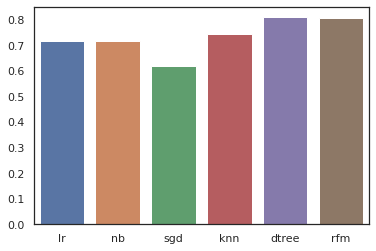

In [11]:
# Accuracy Evaluation
models = [lr, nb, sgd, knn, dtree, rfm]
names = ['lr', 'nb', 'sgd', 'knn', 'dtree', 'rfm']
results = []
for i in range(len(models)):
    result = train_eval(models[i], 'accuracy').mean()
    name = names[i]
    results.append(result)
    print(name + ': ' + str(result))
sns.barplot(names, results)

lr: 0.7348967556935533
nb: 0.7166884800840061
sgd: 0.6128445917670569
knn: 0.7390210491994929
dtree: 0.8052929838975371
rfm: 0.8021554239355375


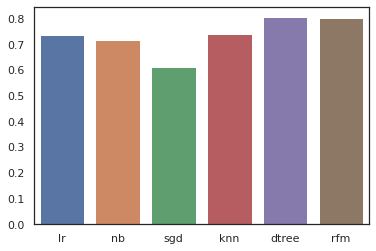

In [12]:
results = []
for i in range(len(models)):
    result = train_eval(models[i], 'precision_weighted').mean()
    name = names[i]
    results.append(result)
    print(name + ': ' + str(result))
sns.barplot(names, results)

lr: 0.6925636241298064
nb: 0.7104307527307658
sgd: 0.5271322635350792
knn: 0.7320802032741246
dtree: 0.8055169497653842
rfm: 0.7957997325695186


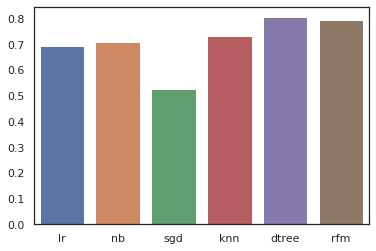

In [13]:
results = []
for i in range(len(models)):
    result = train_eval(models[i], 'f1_weighted').mean()
    name = names[i]
    results.append(result)
    print(name + ': ' + str(result))
sns.barplot(names, results)

lr: 0.7186534894599202
nb: 0.7170011499992776
sgd: 0.6200192321237648
knn: 0.7438953753503728
dtree: 0.8102321603370803
rfm: 0.8089547445710281


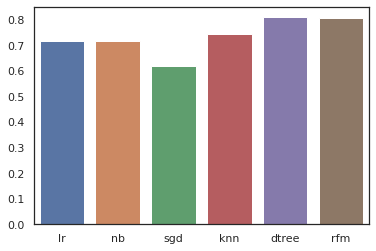

In [14]:
results = []
for i in range(len(models)):
    result = train_eval(models[i], 'recall_weighted').mean()
    name = names[i]
    results.append(result)
    print(name + ': ' + str(result))
sns.barplot(names, results)

# Test data Evaluation

In [15]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [16]:
def test_eval(model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return y_pred

lr: 0.7140281690140845
nb: 0.7125633802816902
sgd: 0.7175211267605633
knn: 0.7877183098591549
dtree: 0.8233239436619718
rfm: 0.8420281690140845


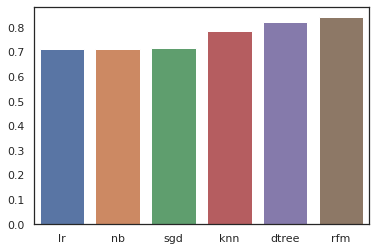

In [17]:
acc = []
precision = []
f1 = []
recall = []
for i in range(len(models)):
    y_pred = test_eval(models[i])
    acc.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    f1.append(f1_score(y_test, y_pred, average='weighted'))
    recall.append(recall_score(y_test, y_pred, average='weighted'))

for i in range(len(models)):
  name = names[i]
  print(name + ': ' + str(acc[i]))
sns.barplot(names, acc)

lr: 0.6947547290135738
nb: 0.7146725790517445
sgd: 0.7192406334193745
knn: 0.782924716124253
dtree: 0.8199268949831401
rfm: 0.8391668298299594


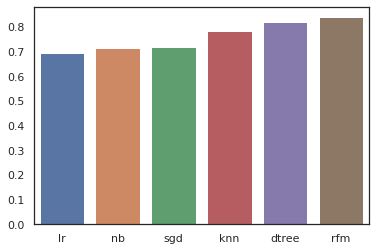

In [18]:
for i in range(len(models)):
  name = names[i]
  print(name + ': ' + str(precision[i]))
sns.barplot(names, precision)

lr: 0.6881953559392845
nb: 0.7056007464835466
sgd: 0.6975096544025468
knn: 0.7817997597042748
dtree: 0.8208597165369335
rfm: 0.8386652396800607


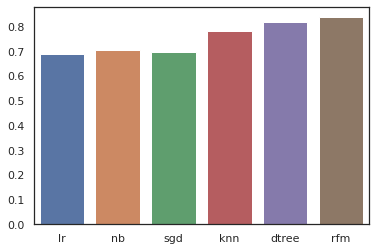

In [19]:
for i in range(len(models)):
  name = names[i]
  print(name + ': ' + str(f1[i]))
sns.barplot(names, f1)

lr: 0.7140281690140845
nb: 0.7125633802816902
sgd: 0.7175211267605633
knn: 0.7877183098591549
dtree: 0.8233239436619718
rfm: 0.8420281690140845


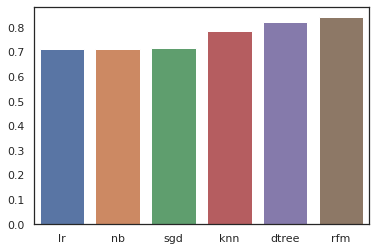

In [20]:
for i in range(len(models)):
  name = names[i]
  print(name + ': ' + str(recall[i]))
sns.barplot(names, recall)